# **sample 100 intergenic regions and simulate to equilibrium** 

In [1]:
!cp ../../../../mutation_equilibrium/analysis/coding_v_noncoding_mutability/intergenic.fasta ./

In [117]:
from Bio import SeqIO
import numpy as np 
import matplotlib.pyplot as plt
import random
import json 
import pandas as pd 
from tqdm import tqdm 

In [8]:
#mutability model 
model = json.load(open("../Human_mutability_model/Model_2020_12_02_genomeWide.txt"))

**data exploration**

In [118]:
intergen_counter = 0
intergen_len = []
for seqRec in tqdm(SeqIO.parse(open("intergenic.fasta"),"fasta")): 
    intergen_counter += 1
    intergen_len.append(len(seqRec.seq))

30452it [00:04, 7110.30it/s] 


In [2]:
intergen_counter = 0
intergen_len = []
for seqRec in SeqIO.parse(open("intergenic.fasta"),"fasta"): 
    intergen_counter += 1
    intergen_len.append(len(seqRec.seq))

(array([8416., 3422., 2532., 1837., 1543., 1332., 1076.,  901.,  791.,
         639.,  603.,  482.,  485.,  428.,  390.,  353.,  290.,  293.,
         259.]),
 array([    0,  5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000,
        45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000,
        90000, 95000]),
 <BarContainer object of 19 artists>)

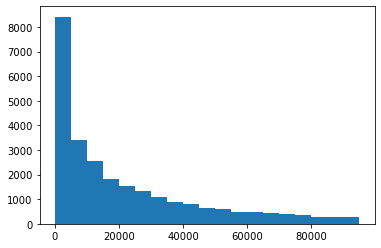

In [84]:
plt.hist(intergen_len, bins=range(0, 100000,5000))

**sample the intergenic**

In [3]:
intergen_ids = []
for seqRec in SeqIO.parse(open("intergenic.fasta"),"fasta"):
    intergen_ids.append(seqRec.id )

In [4]:
chosen_intergen_ids = random.choices(intergen_ids,k=2000) #arbitrarily high sample number to make sure 100 seqs will have length >= 1005

In [97]:
chosen_intergen_randSeq = {}
for seqRec in SeqIO.parse(open("intergenic.fasta"),"fasta"):
    if seqRec.id in chosen_intergen_ids: 
        if len(seqRec.seq) >= 5000: 
            if "N" not in seqRec.seq:
                random_start =random.choice(range(0,len(seqRec)-5000))
                random_seq = str(seqRec.seq[random_start:random_start+5000]).upper()
                chosen_intergen_randSeq[seqRec.id] = random_seq


In [98]:
len(chosen_intergen_randSeq)

1384

In [9]:
# all_muts = []
# for randSeq in chosen_intergen_randSeq.values():
#     assert len(randSeq) == 1000
#     seq_muts = []
#     for i in range(1,len(randSeq)-1): 
#         triplet = randSeq[i-1:i+2]
#         seq_muts.append(model[triplet][0])
#     all_muts.append(np.mean(seq_muts))

In [11]:
# np.mean(seq_muts), np.std(all_muts)/np.sqrt(len(all_muts))

(2.9780098232247944e-05, 1.9641691823111413e-07)

In [99]:
#cut down to 100 n 
chosen_intergen_randSeq_1 = {}
for key in list(chosen_intergen_randSeq.keys())[0:100]:
    chosen_intergen_randSeq_1[key] = chosen_intergen_randSeq[key]

**analyzing the chosen intergen seq**

In [101]:
mut_allNonCDS = []
for seq in chosen_intergen_randSeq_1.values(): 
    assert len(seq)==5000
    mut_seq = []
    for i in range(1,len(seq)-1): 
        triplet = seq[i-1:i+2]
        mut_triplet = model[triplet][0]
        mut_seq.append(mut_triplet)
    mut_allNonCDS.append(np.mean(mut_seq))

In [102]:
np.mean(mut_allNonCDS), np.std(mut_allNonCDS)/np.sqrt(trialN)

(3.370058240981012e-05, 1.0575351238552181e-06)

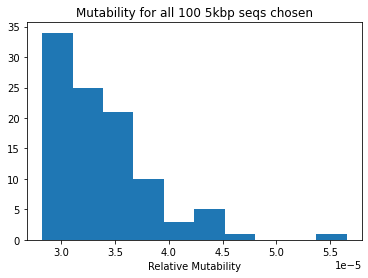

In [103]:
plt.hist(mut_allNonCDS)
plt.xlabel("Relative Mutability")
plt.title("Mutability for all 100 5kbp seqs chosen")
plt.show()

**do the simulation**
- take code from the intronOnly_avMut_2021_03_22.py script 

In [52]:
!cp ../verifying_equilibrium_point/intronOnly_avMut_2021_03_22.py ./

In [20]:
#imports ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from numpy.random import choice
import copy 
#from tqdm import tqdm
import sys 
from datetime import datetime
import time
import timeit
import numpy as np 
import json
from tqdm import tqdm

In [21]:
#defining funtions ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def base_to_mutate(DNA, current_weights, indices): 
    """
    (DNA: str, weights: Dict) -> int
    
    Will return the index of a random choice of a base that will be mutated based on probabilities given by the
    weights dictionary (i.e. the model)
    ex. "ATCGTA" --> index 3 ("G") will mutate
    """

    # NORMALIZE THE POPULATION OF WEIGHTS    
    total_freq = sum(current_weights) - current_weights[0] - current_weights[-1] # remove the start and end weight
    normalized_weights = ["error"]*len(current_weights)
    for index, value in enumerate(current_weights):
        normalized_weights[index] = value/total_freq 
    
    normalized_weights[0] = 0
    normalized_weights[-1] = 0
    # DRAW THE INDEX OF THE BASE THAT WILL BE MUTATED
    base_index = choice(indices, p=normalized_weights) 
    

    # RETURN THE INDEX
    return base_index 

In [22]:
#triplets
triplets = []
for i_1 in ["A", "T", "G", "C"]: 
    for i_2 in ["A", "T", "G", "C"]: 
        for i_3 in ["A", "T", "G", "C"]: 
            triplets.append(i_1+i_2+i_3)

#parameters 
prop_muts = 2

In [105]:
for key,DNA in tqdm(chosen_intergen_randSeq_1.items()): 
# for DNA in chosen_intergen_randSeq: 
    
    trialN = list(chosen_intergen_randSeq_1.keys()).index(key)
    
    #write initial dna 
    file = open("data/humanIntergenic/{t}_DNAI.txt".format(t=trialN), "w")
    file.write(str(DNA))
    file.close()

    #set up ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #triplet-count dict 
    triplet_chosen_count_dict = {}
    triplet_into_count_dict = {}
    for triplet in triplets: 
        triplet_chosen_count_dict[triplet] = [0,0,0]  
        triplet_into_count_dict[triplet] = [0,0,0]

    #making the weights 
    current_weights = []
    for i in range(1,len(DNA)-1): 
        triplet = DNA[i-1:i+2]
        current_weights.append(model[triplet][0])

    indices = [i for i in range(1, len(DNA)-1)]
    mut_indices = []

    #making the av muts lists
    #creating the black plotting lists 
    av_mutability = []
    intron_mut = []
    exon_mut = []

    

    #runnign the sim ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for i in range((int(len(DNA)*prop_muts))):
        base_index = base_to_mutate(DNA, current_weights, indices)

        mut_indices.append(base_index)

        #adding the count for "chosen to mutate" in coutns dict 
        c_triplet = DNA[base_index-1: base_index+2]
        c_triplet_left = DNA[base_index-2: base_index+1]
        c_triplet_right = DNA[base_index: base_index+3]    
        triplet_chosen_count_dict[c_triplet_left][0] += 1
        triplet_chosen_count_dict[c_triplet][1] += 1
        triplet_chosen_count_dict[c_triplet_right][2] += 1

        #accurate model INTO probability ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~OR ^ 
        curr_into_bases = []
        curr_into_bases_probs = []
        for into_base, prob in model[c_triplet][1].items(): 
            curr_into_bases.append(into_base)
            curr_into_bases_probs.append(prob)
        mb =  choice(curr_into_bases, p = curr_into_bases_probs)[1]


        #chanaging the dna 
        DNA = DNA[:base_index]+mb+DNA[base_index+1:]

        #updating the weights 
        m_triplet = c_triplet[0]+mb+c_triplet[2]
        m_triplet_left = c_triplet_left[0:2]+mb
        m_triplet_right = mb+c_triplet_right[1:3]
        current_weights[base_index-2]= model[m_triplet_left][0]    
        current_weights[base_index-1]= model[m_triplet][0]
        current_weights[base_index] = model[m_triplet_right][0]
        
        #adding the count for "mutated into thiss" in the triplet dict 
#         triplet_into_count_dict[m_triplet_left][0] += 1 
#         triplet_into_count_dict[m_triplet][1] += 1 
#         triplet_into_count_dict[m_triplet_right][2] += 1 

        #appending the av mut lists 
        av_mutability.append(np.mean(current_weights))


#     text_file = open("data/{t}_triplet_into_count_dict.txt".format(t=trialN), "w")
#     n = text_file.write(json.dumps(triplet_into_count_dict))
#     text_file.close()

#     text_file = open("data/{t}_triplet_chosen_count_dict.txt".format(t=trialN), "w")
#     n = text_file.write(json.dumps(triplet_chosen_count_dict))
#     text_file.close()

    file = open("data/humanIntergenic/{t}_DNA.txt".format(t=trialN), "w")
    file.write(str(DNA))
    file.close()

    file = open("data/humanIntergenic/{t}_avMut.txt".format(t=trialN), "w")
    file.write(json.dumps(av_mutability))
    file.close()


100%|██████████| 100/100 [27:45<00:00, 16.66s/it]


### **create plotting df**

In [108]:
range(trialN)

range(0, 99)

In [112]:
data_dict = {"gens":[x for x in range(10000)]}
for i in tqdm(range(trialN)): 
    data_dict["trial"+str(i)] = json.load(open("data/humanIntergenic/{}_avMut.txt".format(i)))

100%|██████████| 99/99 [00:00<00:00, 209.58it/s]


In [113]:
data_df = pd.DataFrame.from_dict(data_dict)

In [116]:
data_df.to_csv("data/humanIntergenic/data_df_5kbp.csv")

### **plottign average**

In [38]:
avMut_allNonCDS = []
stderrMut_allNonCDS = []
for i in tqdm(range(len(json.load(open("data/humanIntergenic/1_avMut.txt"))))): 
    avMuts_pos = []
    for j in range(trialN): 
        avMuts_pos.append(json.load(open("data/humanIntergenic/{}_avMut.txt".format(j)))[i])
    avMut_allNonCDS.append(np.mean(avMuts_pos))
    stderrMut_allNonCDS.append(np.std(avMuts_pos)/np.sqrt(100))# 100 = the number of trials

100%|██████████| 2000/2000 [03:00<00:00, 11.08it/s]


In [29]:
avMut_allNonCDS[-1], stderrMut_allNonCDS[-1]

(2.93007076963938e-05, 1.5080979157990998e-07)

In [39]:
avMut_allNonCDS[-1], stderrMut_allNonCDS[-1]

(2.9138002107897025e-05, 1.3353437225941693e-07)

In [43]:
belowError_allNonCDS =  []
aboveError_allNonCDS = []
for avMut, stderr in zip(avMut_allNonCDS, stderrMut_allNonCDS): 
    belowError_allNonCDS.append(avMut-stderr)
    aboveError_allNonCDS.append(avMut+stderr)
belowError_allNonCDS = np.array(belowError_allNonCDS)
aboveError_allNonCDS = np.array(aboveError_allNonCDS)

In [44]:
len([x for x in range(2000)])

2000

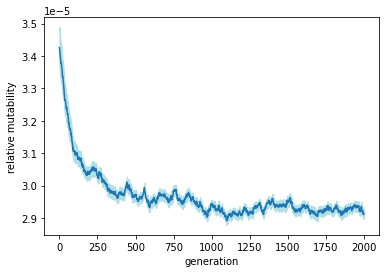

In [76]:
plt.plot([x for x in range(2000)],avMut_allNonCDS)

plt.fill_between([x for x in range(2000)],belowError_allNonCDS,aboveError_allNonCDS, color = "powderblue")
# plt.show()
# timestamp = datetime.now().strftime("%Y/%m/%d_%H:%M:%S").replace("/", "_").replace(":", "_")
# plt.tight_layout()
plt.xlabel("generation")
plt.ylabel("relative mutability")
plt.show()
# plt.savefig("plots/equilibrium_humanIntergenic_100n_1kbp_2xCov_stderr_trial2.pdf")